Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [3]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [4]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [5]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [6]:
df['BUILDING_CLASS_CATEGORY'].value_counts()

01 ONE FAMILY DWELLINGS                       5061
02 TWO FAMILY DWELLINGS                       4567
10 COOPS - ELEVATOR APARTMENTS                3471
13 CONDOS - ELEVATOR APARTMENTS               3339
03 THREE FAMILY DWELLINGS                     1438
07 RENTALS - WALKUP APARTMENTS                 807
09 COOPS - WALKUP APARTMENTS                   672
15 CONDOS - 2-10 UNIT RESIDENTIAL              421
04 TAX CLASS 1 CONDOS                          418
44 CONDO PARKING                               366
17 CONDO COOPS                                 300
22 STORE BUILDINGS                             288
05 TAX CLASS 1 VACANT LAND                     288
12 CONDOS - WALKUP APARTMENTS                  256
14 RENTALS - 4-10 UNIT                         200
29 COMMERCIAL GARAGES                          147
08 RENTALS - ELEVATOR APARTMENTS               120
30 WAREHOUSES                                  105
21 OFFICE BUILDINGS                             96
31 COMMERCIAL VACANT LAND      

In [7]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [8]:
small = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']  # Narrow subset down by category

In [9]:
small['BUILDING_CLASS_CATEGORY'].value_counts()

01 ONE FAMILY DWELLINGS    5061
Name: BUILDING_CLASS_CATEGORY, dtype: int64

In [10]:
lower_bound = 100000
upper_bound = 2000000

smaller = small[(small['SALE_PRICE'] > lower_bound) &
                (small['SALE_PRICE'] <= upper_bound)]

In [11]:
smaller['SALE_DATE'].value_counts()

01/31/2019    78
03/29/2019    62
02/28/2019    58
01/15/2019    57
01/24/2019    56
              ..
03/17/2019     1
03/09/2019     1
03/30/2019     1
02/17/2019     1
04/14/2019     1
Name: SALE_DATE, Length: 91, dtype: int64

In [22]:
smaller.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [23]:
# smaller['SALE_DATE'] = pd.to_datetime(smaller['SALE_DATE'], infer_datetime_format=True)

cutoff = '04/01/2019'
train = smaller[smaller.SALE_DATE < cutoff]
test  = smaller[smaller.SALE_DATE >= cutoff]

In [25]:
test['SALE_DATE'].value_counts()

04/15/2019    43
04/01/2019    41
04/10/2019    41
04/02/2019    41
04/04/2019    40
04/09/2019    39
04/12/2019    35
04/18/2019    35
04/03/2019    33
04/05/2019    33
04/11/2019    32
04/16/2019    31
04/17/2019    28
04/30/2019    26
04/08/2019    26
04/29/2019    22
04/22/2019    21
04/25/2019    18
04/19/2019    18
04/23/2019    18
04/24/2019    15
04/26/2019     8
04/14/2019     1
Name: SALE_DATE, dtype: int64

In [14]:
train.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,3154,3154,3154,3154,3154,3154,1,3154,3154,3154
unique,5,7,1,2,13,3138,1,1036,11,91
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,118-20 202ND STREET,RP.,"4,000",A1,01/31/2019
freq,1580,2962,3154,3114,1185,2,1,289,1186,78


In [15]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'LAND_SQUARE_FEET', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality + ['EASE-MENT'])

features

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'APARTMENT_NUMBER', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [26]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [29]:
import category_encoders as ce
import pandas.util.testing as tm

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [30]:
X_test.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,APARTMENT_NUMBER_nan,APARTMENT_NUMBER_RP.,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
18235,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,5913,878,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,10471.0,1.0,0.0,1.0,2272.0,1930.0,1,0,1,0,0,0,0,0,0,0,0,0
18239,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,5488,48,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,10465.0,1.0,0.0,1.0,720.0,1935.0,1,0,0,0,0,1,0,0,0,0,0,0
18244,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5936,31,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,11209.0,1.0,0.0,1.0,2210.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
18280,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,7813,24,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,11210.0,1.0,0.0,1.0,1520.0,1915.0,1,0,0,1,0,0,0,0,0,0,0,0
18285,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,8831,160,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,11229.0,1.0,0.0,1.0,840.0,1925.0,1,1,0,0,0,0,0,0,0,0,0,0


In [37]:
# Select the best correlated features - start with 15 - Changed to 10 after identifying simplest model with plateau in MAE

# .fit_transform on the train set
# .transform on test set

from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(k=10)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train.shape, X_test.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 12 28 29 30 31 38 49] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


((2509, 50), (645, 50))

In [38]:
X_train_selected.shape, X_test_selected.shape

((2509, 10), (645, 10))

In [39]:
X_train_selected

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
selected_mask = selector.get_support()
selected_mask
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
BOROUGH_1
NEIGHBORHOOD_ASTORIA
BUILDING_CLASS_AT_PRESENT_A3
BUILDING_CLASS_AT_PRESENT_S0
BUILDING_CLASS_AT_PRESENT_B3
APARTMENT_NUMBER_nan
APARTMENT_NUMBER_RP.
BUILDING_CLASS_AT_TIME_OF_SALE_A3
BUILDING_CLASS_AT_TIME_OF_SALE_A6
BUILDING_CLASS_AT_TIME_OF_SALE_S0


Features not selected:
BOROUGH_3
BOROUGH_4
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_EAST NEW YORK
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
BLOCK
LOT
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_B2
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
YEAR_BUILT
TAX_CLASS_AT_TIM

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

1 features
Test Mean Absolute Error: $185,356 

2 features
Test Mean Absolute Error: $184,271 

3 features
Test Mean Absolute Error: $184,271 

4 features
Test Mean Absolute Error: $185,135 

5 features
Test Mean Absolute Error: $183,647 

6 features
Test Mean Absolute Error: $178,220 

7 features
Test Mean Absolute Error: $178,762 

8 features
Test Mean Absolute Error: $173,688 

9 features
Test Mean Absolute Error: $173,427 

10 features
Test Mean Absolute Error: $165,098 

11 features
Test Mean Absolute Error: $164,307 

12 features
Test Mean Absolute Error: $163,856 

13 features
Test Mean Absolute Error: $165,122 

14 features
Test Mean Absolute Error: $164,086 

15 features
Test Mean Absolute Error: $164,089 

16 features
Test Mean Absolute Error: $163,944 

17 features
Test Mean Absolute Error: $163,944 

18 features
Test Mean Absolute Error: $163,705 

19 features
Test Mean Absolute Error: $163,705 

20 features
Test Mean Absolute Error: $163,732 

21 features
Test Mean Absolut

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

Test Mean Absolute Error: $159,437 

23 features
Test Mean Absolute Error: $159,437 

24 features
Test Mean Absolute Error: $159,437 

25 features
Test Mean Absolute Error: $159,437 

26 features
Test Mean Absolute Error: $159,172 

27 features
Test Mean Absolute Error: $159,055 

28 features
Test Mean Absolute Error: $158,989 

29 features
Test Mean Absolute Error: $158,946 

30 features
Test Mean Absolute Error: $159,019 

31 features
Test Mean Absolute Error: $160,049 

32 features
Test Mean Absolute Error: $160,059 

33 features
Test Mean Absolute Error: $159,679 

34 features
Test Mean Absolute Error: $159,656 

35 features
Test Mean Absolute Error: $159,679 

36 features
Test Mean Absolute Error: $160,695 

37 features
Test Mean Absolute Error: $160,398 

38 features
Test Mean Absolute Error: $160,398 

39 features
Test Mean Absolute Error: $159,752 

40 features


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  retu

Test Mean Absolute Error: $159,809 

41 features
Test Mean Absolute Error: $159,804 

42 features
Test Mean Absolute Error: $159,804 

43 features
Test Mean Absolute Error: $159,820 

44 features
Test Mean Absolute Error: $159,801 

45 features
Test Mean Absolute Error: $159,800 

46 features
Test Mean Absolute Error: $160,117 

47 features
Test Mean Absolute Error: $160,088 

48 features
Test Mean Absolute Error: $160,117 

49 features
Test Mean Absolute Error: $160,122 

50 features
Test Mean Absolute Error: $160,118 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

In [44]:
from IPython.display import display, HTML

import seaborn as sns

%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

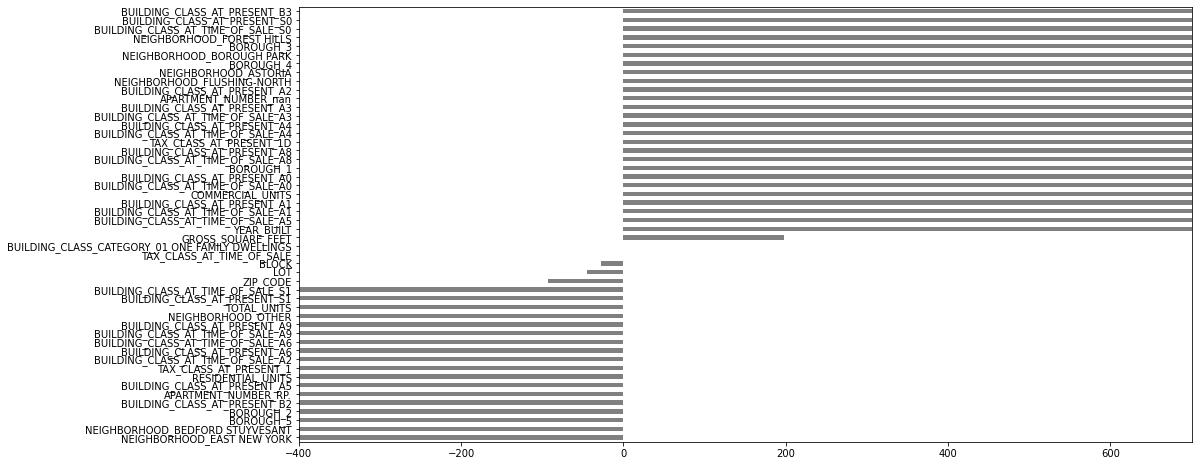

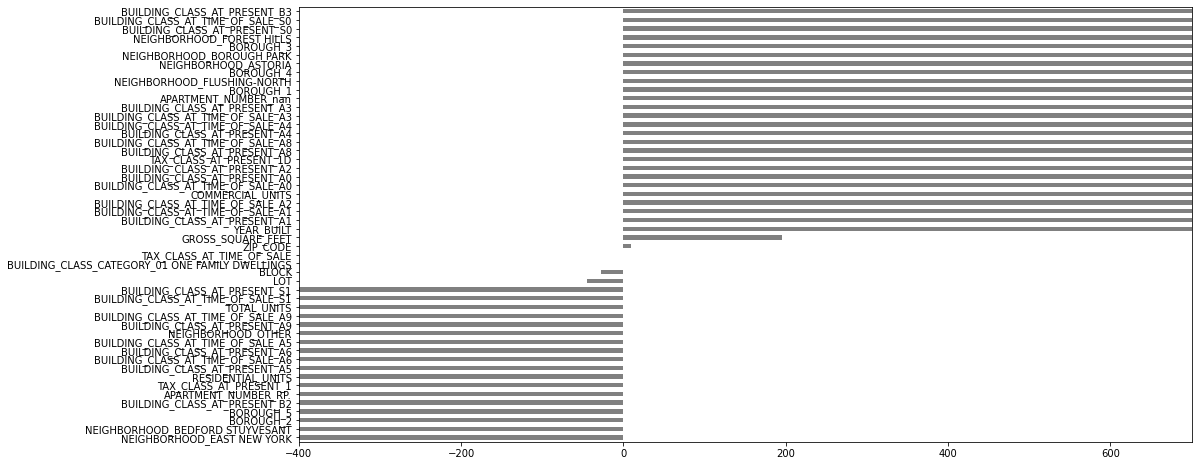

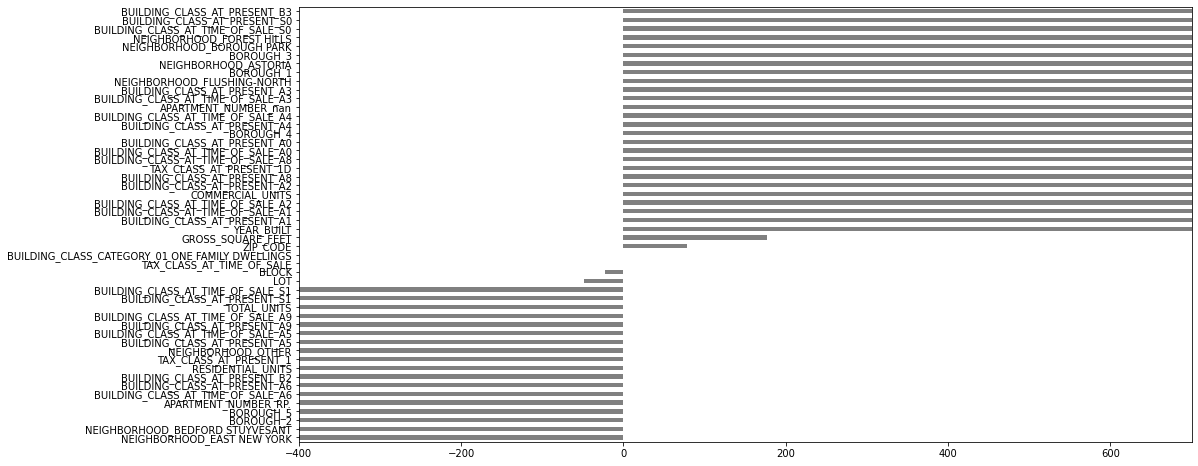

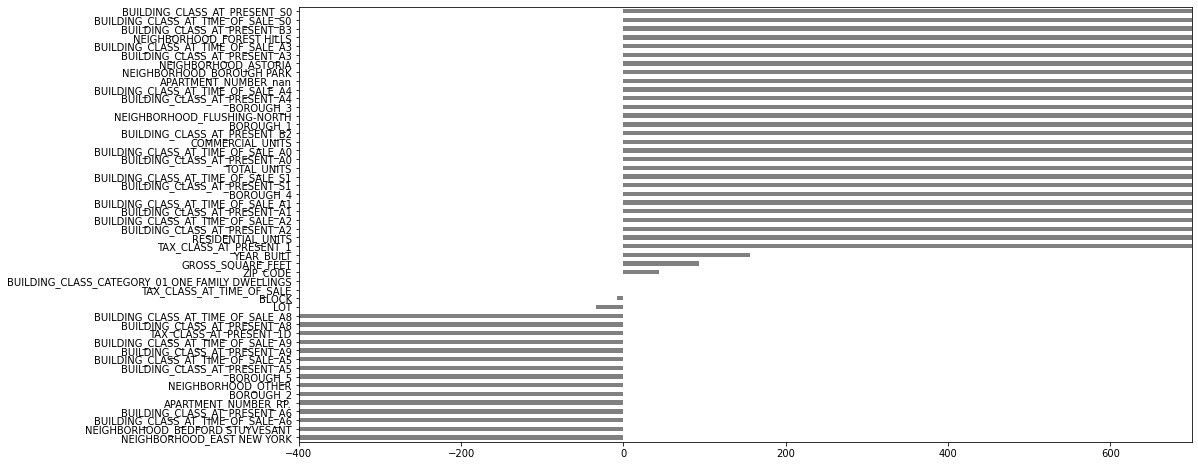

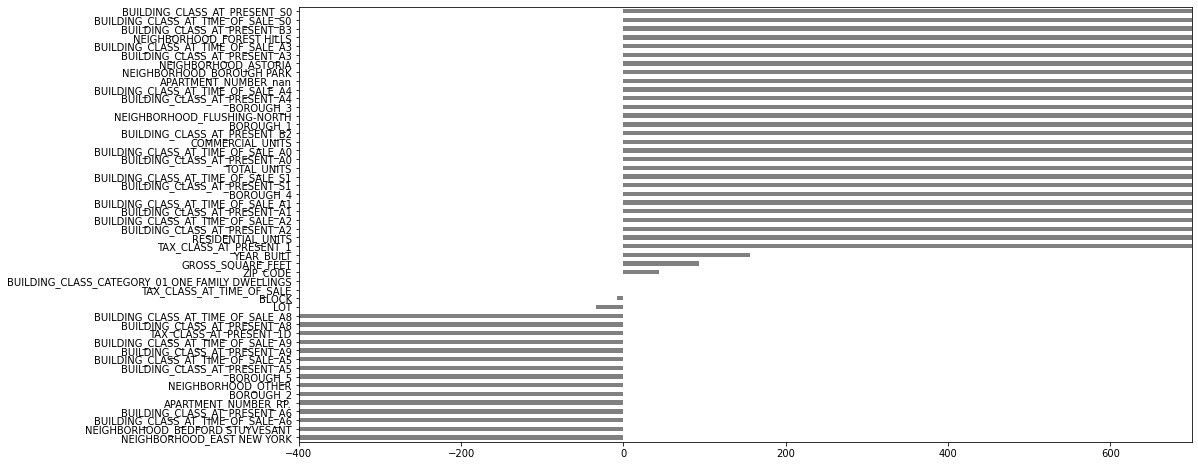

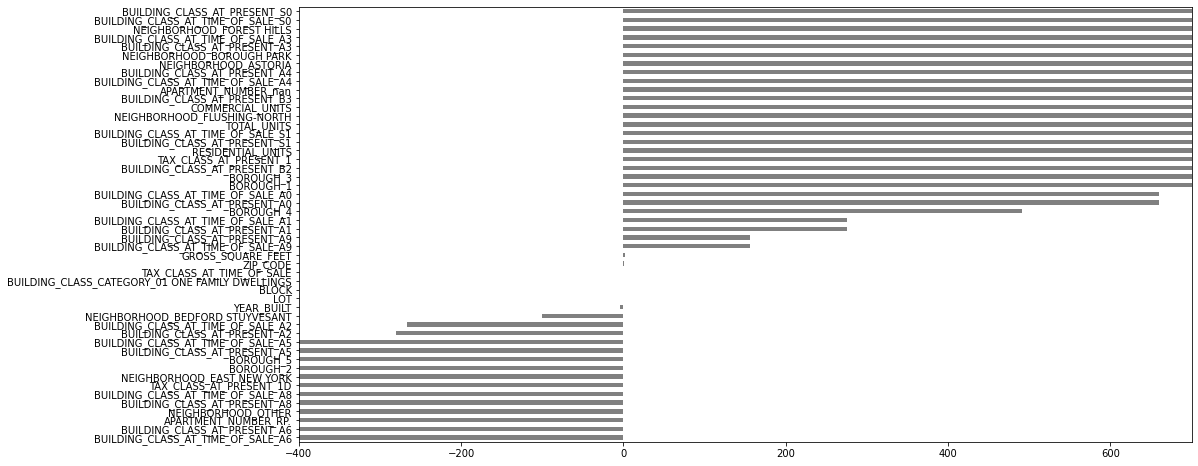

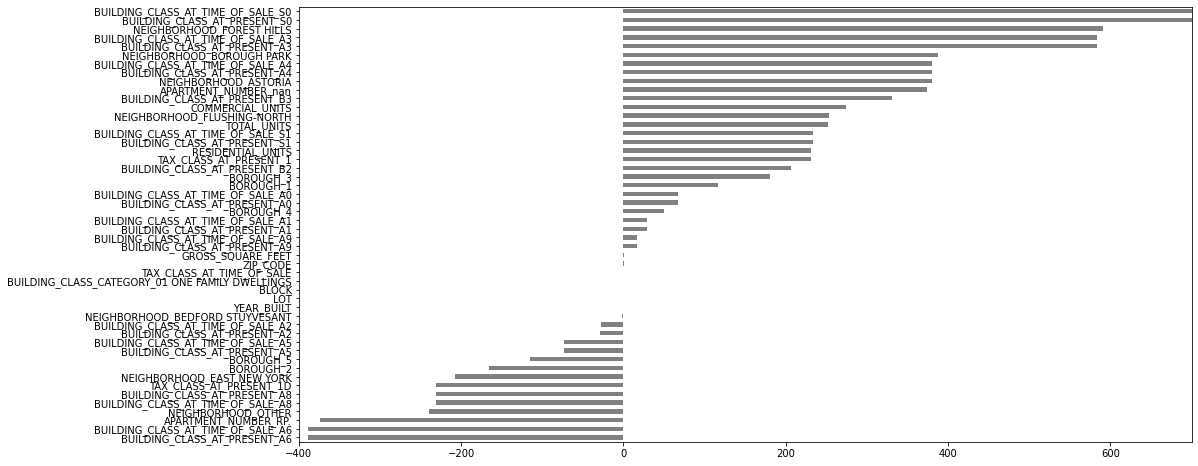

In [45]:
for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,700)
    plt.show()

In [ ]:
# Select Ridge Regression, with alpha=0.1
# Lowest Test Mean Absolute Error: $159,151